<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/decision_tree/03_pos_pruning_tree_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    make_scorer,
    recall_score,
    precision_score)
from sklearn.datasets import make_regression, make_friedman1, make_classification

#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

The focus of this project is to demonstrate the process of post-pruning in decision trees.

# **Data**
---

A synthetic, non-linear dataset will be generated for the regression problem and  data for the classification problem. Since the idea is to demonstrate a proof of concept, this approach is adopted to minimize the impact on processing time.

# **Config**
---

In [2]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.5f}'.format)
random_seed = 12354
warnings.filterwarnings('ignore')

# **Data**
---

The use the make_friedman1 function from scikit-learn, as it allows to generate a non-linear dataset


In [3]:
X, y = make_friedman1(n_samples=100, n_features=8, noise=1.8, random_state=random_seed)

In [4]:
#X, y = make_regression(n_samples=500, n_features=8, n_informative=5, bias=0.0, noise=80, random_state=random_seed)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,0.55196,0.10971,0.02975,0.42802,0.56019,0.79467,0.46556,0.34588
1,0.33711,0.20498,0.45069,0.14943,0.78478,0.29625,0.86917,0.45280
2,0.21115,0.90488,0.33384,0.78674,0.49532,0.44739,0.82070,0.37170
3,0.47144,0.02144,0.23761,0.70976,0.57599,0.41125,0.71222,0.16422
4,0.55229,0.84667,0.78529,0.98003,0.86330,0.05351,0.08885,0.50807
...,...,...,...,...,...,...,...,...
95,0.92742,0.74407,0.99237,0.17964,0.07456,0.90571,0.10928,0.28163
96,0.97835,0.52388,0.93043,0.23220,0.43871,0.11778,0.42102,0.20498
97,0.20436,0.67438,0.86219,0.11305,0.46138,0.62614,0.57774,0.85317
98,0.04949,0.16050,0.02240,0.47459,0.00695,0.38148,0.76282,0.46000


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_seed)

**Pos Pruning**

This function allows for plotting three versions to calculate the best pruning alpha:

1. Comparison of test data and training data, validating a metric such as R^2 to assess how well the model fits the data.

2. Comparison of test data and training data, validating a performance or error metric such as MAE.

3. Comparison of data by validating a performance or error metric such as MAE, using techniques to assess the model's effectiveness through multiple iterations, such as cross-validation.

The other three plots allow for visualizing impurity, the number of nodes, and depth against the range of alpha values.

In [6]:
def cost_complexity_pruning_plot(
  ccp_alphas,
  impurities,
  node_counts,
  depth,
  train_scores,
  test_scores,
  cro_cv,
  score_trainer,
  score_test,
  typ = 'R'
):
  try:

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    ax[0,0].plot(ccp_alphas, score_trainer, marker="o", label="train", drawstyle="steps-post")
    ax[0,0].plot(ccp_alphas, score_test, marker="o", label="test", drawstyle="steps-post")
    ax[0,0].set_xlabel("Alpha")
    ax[0,0].set_ylabel("Score")
    ax[0,0].set_title("Score vs alpha for training and testing sets")
    i_score_test = score_test.index(max(score_test))
    ax[0,0].axvline(ccp_alphas[i_score_test], linestyle='--', label=f'Best Alpha: {ccp_alphas[i_score_test]}', color='g')
    ax[0,0].axhline(score_test[i_score_test], linestyle='--', label=f'Best Score: {score_test[i_score_test]}', color='g')
    ax[0,0].legend()

    i_metric= 0
    i_cross = 0
    if typ=='R':
      i_metric = test_scores.index(min(test_scores))
      i_cross = cro_cv.index(min(cro_cv))
    elif typ=='C':
      i_metric = test_scores.index(max(test_scores))
      i_cross = cro_cv.index(max(cro_cv))

    ax[0,1].plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax[0,1].plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
    ax[0,1].set_xlabel("Alpha")
    ax[0,1].set_ylabel("Metric")
    ax[0,1].set_title("Metric vs alpha for training and testing sets")
    ax[0,1].axvline(ccp_alphas[i_metric], linestyle='--', label=f'Best Alpha: {ccp_alphas[i_metric]}', color='brown')
    ax[0,1].axhline(test_scores[i_metric], linestyle='--', label=f'Best metric: {test_scores[i_metric]}', color='brown')
    ax[0,1].legend()


    ax[0,2].plot(ccp_alphas, cro_cv, marker="o", label="test", drawstyle="steps-post")
    ax[0,2].set_xlabel("Alpha")
    ax[0,2].set_ylabel("Mean Score Cross Validation ")
    ax[0,2].set_title("Cross Validation vs alpha")
    ax[0,2].axvline(ccp_alphas[i_cross], linestyle='--', label=f'Best Alpha: {ccp_alphas[i_cross]}', color='olive')
    ax[0,2].axhline(cro_cv[i_cross], linestyle='--', label=f'Best Cross_v: {cro_cv[i_cross]}', color='olive')
    ax[0,2].legend()



    #best_alpha = ccp_alphas[cro_cv.index(max(cro_cv))]
    #print(best_alpha)

    ax[1,0].plot(ccp_alphas, impurities, marker="o", drawstyle='steps-post')
    ax[1,0].set_xlabel("Effective alpha")
    ax[1,0].set_ylabel("Total impurity of leaves")
    ax[1,0].set_title("Total Impurity vs effective alpha for training set")

    ax[1,1].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
    ax[1,1].set_xlabel("Alpha")
    ax[1,1].set_ylabel("Number of nodes")
    ax[1,1].set_title("Number of nodes vs alpha")

    ax[1,2].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
    ax[1,2].set_xlabel("alpha")
    ax[1,2].set_ylabel("depth of tree")
    ax[1,2].set_title("Depth vs alpha")

    dta = [
        (
            'Score',
            ccp_alphas[i_score_test],
            score_test[i_score_test],
            impurities[i_score_test],
            node_counts[i_score_test],
            depth[i_score_test],

        ),
        (
            'Metric',
            ccp_alphas[i_metric],
            test_scores[i_metric],
            impurities[i_metric],
            node_counts[i_metric],
            depth[i_metric],

        ),
        (
            'cv-n',
            ccp_alphas[i_cross],
            cro_cv[i_cross],
            impurities[i_cross],
            node_counts[i_cross],
            depth[i_cross],

        )
    ]

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

    return pd.DataFrame(dta, columns=
     ['', 'ccp_alphas', 'value', 'impurities', 'nodes', 'depth'])
  except Exception as e:
    print(e)

# **Regression**
---

**Data Nonlinear**

In [7]:
model_regresion = DecisionTreeRegressor(random_state=random_seed)

The regression model is instantiated, and the Minimal Cost-Complexity Pruning algorithm from scikit-learn is applied [source](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

1. R^2 is used to validate the variability.

2. MSE is used to validate the error.

3. MAE is used to assess data performance through cross-validation.

In [8]:
cost = model_regresion.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = cost.ccp_alphas, cost.impurities


node_counts = []
depth = []
train_scores = []
test_scores = []
models = []
cro_cv = []
score_trainer = []
score_test = []
for ccp_alpha in ccp_alphas:
  model = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=ccp_alpha)
  cro_cv.append(-1*cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error').mean())
  model.fit(X_train, y_train)
  score_trainer.append(model.score(X_train, y_train))
  score_test.append(model.score(X_test, y_test))
  node_counts.append(model.tree_.node_count)
  depth.append(model.tree_.max_depth)
  train_scores.append(mean_squared_error(y_train, model.predict(X_train), squared=False))
  test_scores.append(mean_squared_error(y_test, model.predict(X_test),squared=False))
  models.append(model)

1. For point 1, the best alpha is 0.8231471. Why is the highest alpha selected? Since the metric is the coefficient of determination, the look for the alpha that allows us to find the model that best explains the variability.


2. For point 2, the alpha that minimizes the error on the training dataset should be selected. In this case, it is 0.8231471.

3. For point 3, since cross-validation is used and its concept involves utilizing all the data, all the data is employed,  Therefore, the look for the alpha that best reduces the error.


- It is possible that the alphas may coincide.

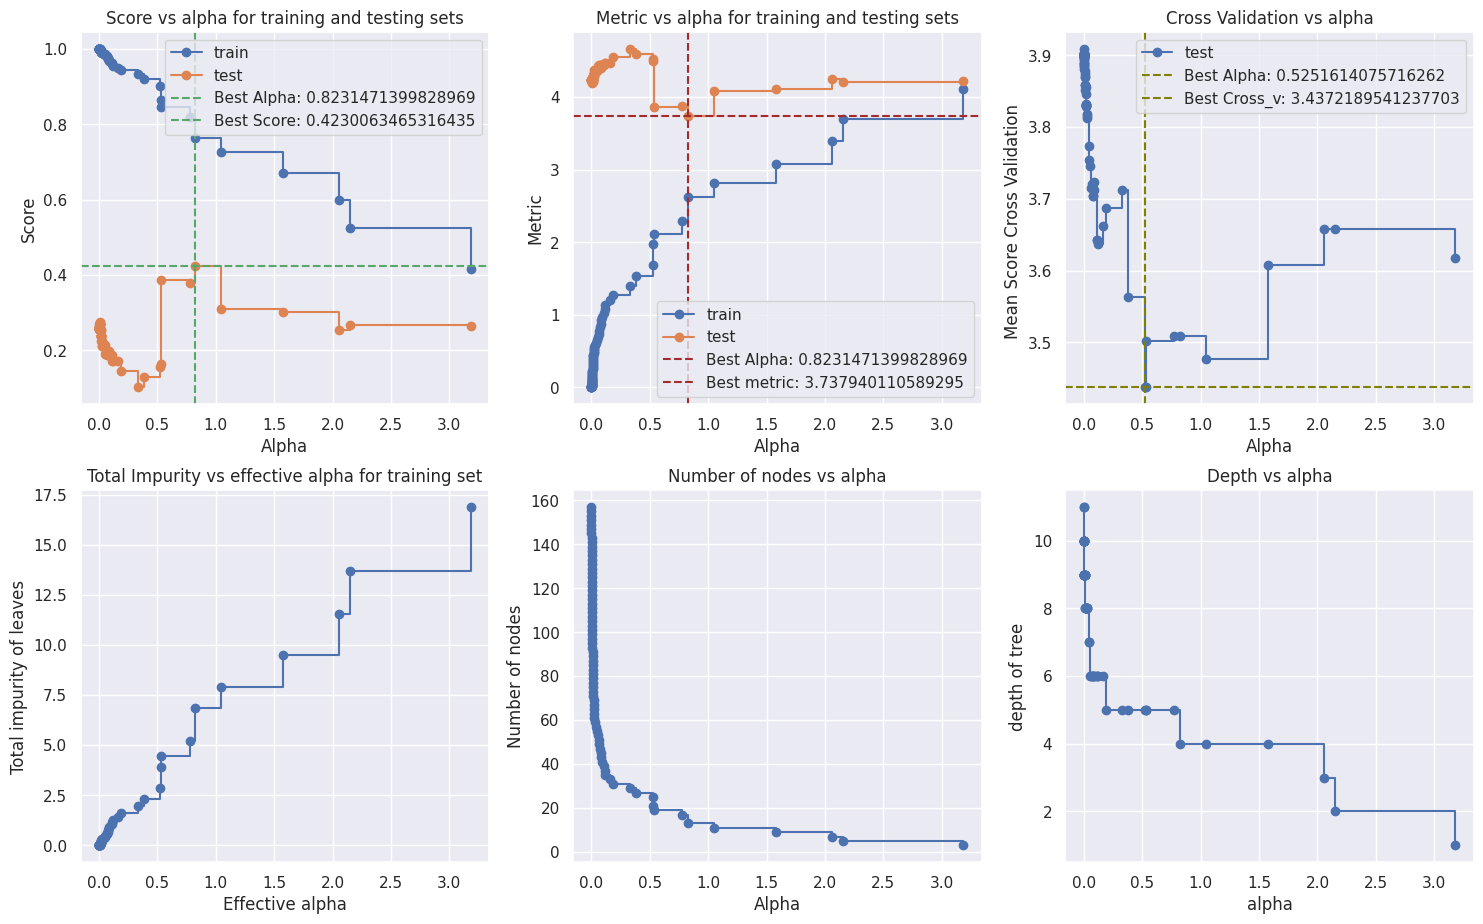

In [9]:
dta = cost_complexity_pruning_plot(
    ccp_alphas[1:-1],
    impurities[1:-1],
    node_counts[1:-1],
    depth[1:-1],
    train_scores[1:-1],
    test_scores[1:-1],
    cro_cv[1:-1],
    score_trainer[1:-1],
    score_test[1:-1],
    typ = 'R')

In [10]:
dta

,,ccp_alphas,value,impurities,nodes,depth
0,Score,0.82315,0.42301,6.87162,13,4
1,Metric,0.82315,3.73794,6.87162,13,4
2,cv-n,0.52516,3.43722,2.85777,25,5


The three common metrics: MAE, RMSE, and MAE are used to validate the three alphas and the model with overfitting.

In [11]:
model_regresion = DecisionTreeRegressor(random_state=random_seed)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)

print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 17.93586359316587 RMSE: 4.235075394035609 MAE: 3.3776401747081595


In [12]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=0.8231471399828969)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 13.972196270352313 RMSE: 3.737940110589295 MAE: 3.120486109396869


In [13]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=0.8231471399828969)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 13.972196270352313 RMSE: 3.737940110589295 MAE: 3.120486109396869


In [14]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=0.5251614075716262)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 20.410582289318207 RMSE: 4.517807243488616 MAE: 3.542071229069576


The best alpha is 0.8231471399828969. In this case, this alpha effectively reduces the error and optimally explains the variance.

**Data linear**

Now, a linear dataset will be generated.

In [15]:
X, y = make_regression(n_samples=500, n_features=8, n_informative=5, bias=0.0, noise=80, random_state=random_seed)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,0.33309,0.40515,-0.29568,0.03915,0.62578,0.03084,2.14020,-2.30404
1,0.64701,0.97186,-0.25811,0.18368,-0.05451,0.66951,0.03158,0.35562
2,1.18575,-1.84027,0.01981,-0.23854,-0.56441,-1.03689,-1.20976,-1.75251
3,0.55373,0.92211,0.37396,0.66754,1.27186,-0.16641,0.60589,0.36458
4,-0.55459,-0.23257,2.49568,-0.18946,-0.29539,-1.20166,-1.05297,0.29651
...,...,...,...,...,...,...,...,...
495,-0.38648,0.78051,-0.01369,-1.73480,-1.62471,1.14644,-0.73190,0.20413
496,0.26934,1.02124,0.17559,0.91135,0.35462,-0.04796,-0.18890,-1.32060
497,0.04411,-1.40635,-2.06421,-0.57773,0.48997,-1.27363,-0.09255,0.12158
498,0.93807,0.05416,-0.80141,-2.41603,-0.46104,0.95923,-1.20203,1.72506


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_seed)

In [17]:
model_regresion = DecisionTreeRegressor(random_state=random_seed)

The regression model is instantiated, and the Minimal Cost-Complexity Pruning algorithm from scikit-learn is applied [source](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

1. R^2 is used to validate the variability.

2. MAE is used to validate the error.

3. MSE is used to assess data performance through cross-validation.

In [18]:
cost = model_regresion.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = cost.ccp_alphas, cost.impurities


node_counts = []
depth = []
train_scores = []
test_scores = []
models = []
cro_cv = []
score_trainer = []
score_test = []
for ccp_alpha in ccp_alphas:
  model = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=ccp_alpha)
  cro_cv.append(-1*cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error').mean())
  model.fit(X_train, y_train)
  score_trainer.append(model.score(X_train, y_train))
  score_test.append(model.score(X_test, y_test))
  node_counts.append(model.tree_.node_count)
  depth.append(model.tree_.max_depth)
  train_scores.append(mean_absolute_error(y_train, model.predict(X_train)))
  test_scores.append(mean_absolute_error(y_test, model.predict(X_test)))
  models.append(model)

1. For point 1, the best alpha is 87.05214066760358. Why is the highest alpha selected? Since the metric is the coefficient of determination, the look for the alpha that allows us to find the model that best explains the variability.


2. For point 2, the alpha that minimizes the error on the training dataset should be selected. In this case, it is 100.37026289232307.

3. For point 3, since cross-validation is used and its concept involves utilizing all the data, all the data is employed,  Therefore, the look for the alpha that best reduces the error. The best alpha is 165.1978707557911


- It is possible that the alphas may coincide.

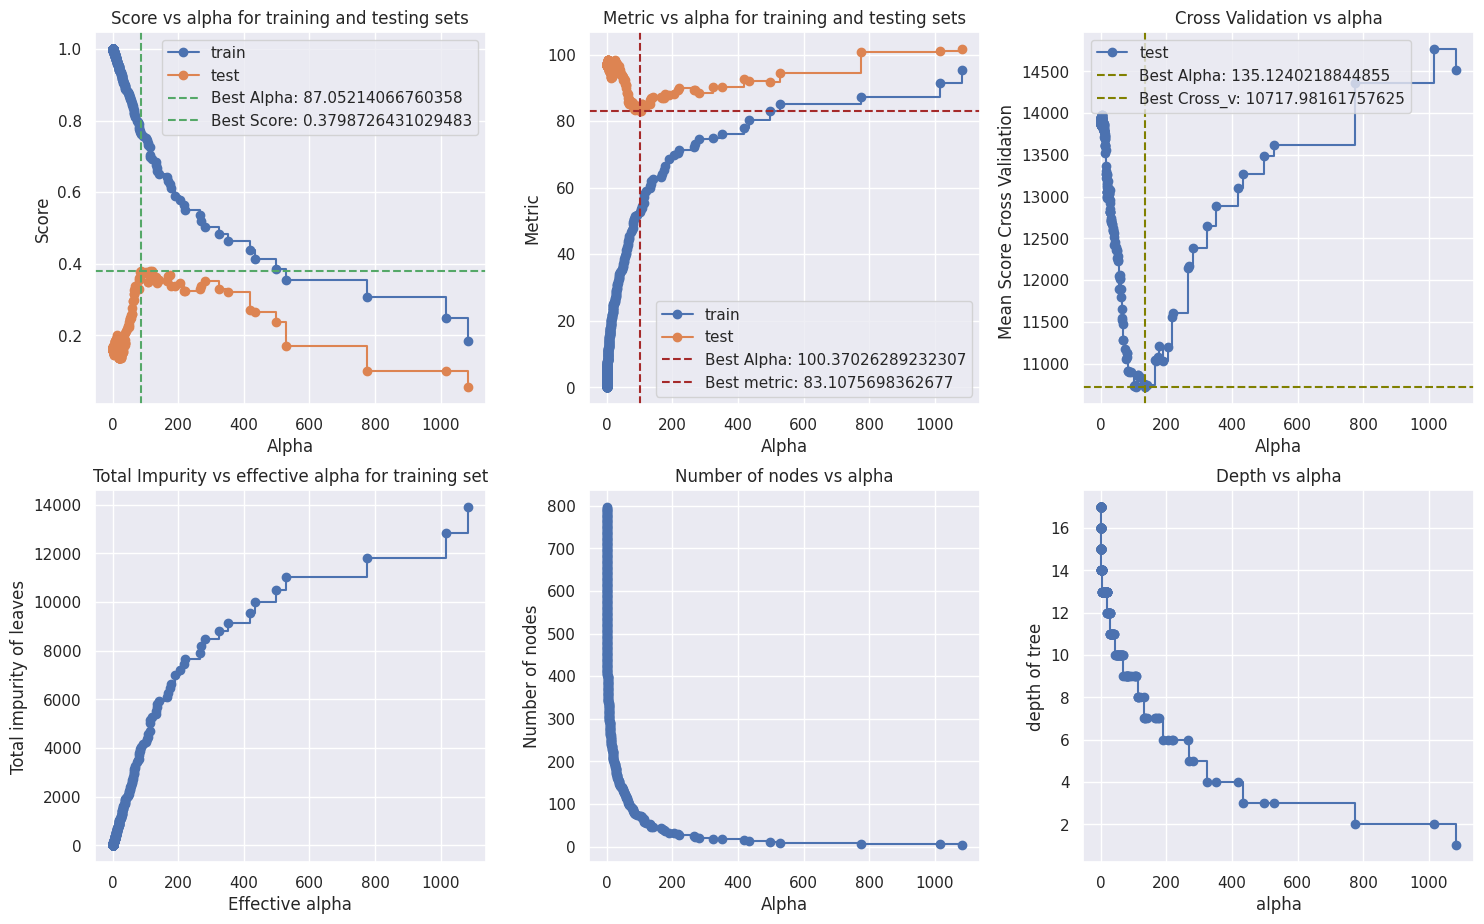

In [19]:
dta = cost_complexity_pruning_plot(
    ccp_alphas[1:-1],
    impurities[1:-1],
    node_counts[1:-1],
    depth[1:-1],
    train_scores[1:-1],
    test_scores[1:-1],
    cro_cv[1:-1],
    score_trainer[1:-1],
    score_test[1:-1],
    typ = 'R')

In [20]:
dta

,,ccp_alphas,value,impurities,nodes,depth
0,Score,87.05214,0.37987,"4,061.17243",77,9
1,Metric,100.37026,83.10757,"4,252.83419",73,9
2,cv-n,135.12402,"10,717.98162","5,803.62284",47,7


The three common metrics: MAE, RMSE, and MAE are used to validate the three alphas and the model with overfitting.

In [21]:
model_regresion = DecisionTreeRegressor(random_state=random_seed)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)

print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 14038.655053025172 RMSE: 118.48483047641656 MAE: 96.86619715602922


In [22]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=87.05214)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 10392.347421401975 RMSE: 101.94286351384277 MAE: 83.65425390857317


In [23]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=100.37026)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 10419.623487502875 RMSE: 102.07655699279279 MAE: 83.59300976208065


In [24]:
model_regresion = DecisionTreeRegressor(random_state=random_seed, ccp_alpha=135.12402)

model_regresion.fit(X_train, y_train)
y_predict = model_regresion.predict(X_test)
print(
    f'MSE: {mean_squared_error(y_test, y_predict)}',
    f'RMSE: {mean_squared_error(y_test, y_predict, squared=False)}',
    f'MAE: {mean_absolute_error(y_test, y_predict)}'
)

MSE: 10884.748133351759 RMSE: 104.32999632584945 MAE: 86.5552019580349


The best alpha is 87.05214.

# **Calsification**
---

A class-imbalanced dataset with two categories is generated. It is noted that the post-pruning method is applicable to various classification problems with different categories, whether the data is balanced or imbalanced.


In [25]:
X, y = make_classification(
    n_samples=1500,
    n_features=8,
    n_informative=5,
    n_redundant=0,
    random_state=random_seed,
    n_clusters_per_class=1,
    weights=[0.75, 0.25])

In [26]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,0.22471,1.23099,1.68059,-0.36836,-1.04167,1.10834,-0.58853,-0.30295
1,0.85334,1.31614,-0.49079,-1.50996,0.63583,-1.01082,0.65669,-0.11655
2,0.45679,0.57656,-1.22637,0.59500,0.25821,-1.60386,0.57440,-2.77262
3,0.69265,0.12947,0.75555,0.26229,2.29743,0.20151,1.43149,0.31618
4,-1.58436,0.82152,0.60969,-1.67849,0.19365,-0.88295,-1.66015,-0.46022
...,...,...,...,...,...,...,...,...
1495,0.62186,0.05846,1.88119,-1.27950,-0.49568,-0.31654,-1.02041,-1.91427
1496,0.27373,2.30224,-0.35701,-2.27038,1.39855,0.62136,1.62982,1.36632
1497,0.04061,-0.43761,1.98648,-0.55027,-0.40916,-1.84958,-1.90737,-0.75453
1498,1.30011,-0.87217,0.09780,-2.09479,-3.25659,1.97739,-1.79688,-0.13896


In [27]:
model_clasification = DecisionTreeClassifier(random_state=random_seed)

In [28]:
pd.Series(y).value_counts()

,count
0,1119
1,381


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=random_seed, stratify=y)

The clasification model is instantiated, and the Minimal Cost-Complexity Pruning algorithm from scikit-learn is applied [source](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

1. **Accuracy** validate how well the model fits the data. In this context, accuracy is used as it is the default metric. However, for imbalanced classification problems, it is better to analyze the alpha in more detail

2. precision is used to validate the error.  With these metrics, the goal is not to find the lowest error but to achieve the highest performance score of the model in relation to the classification of the class

3. recall is used to assess data performance through cross-validation.




In [30]:
cost = model_regresion.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = cost.ccp_alphas, cost.impurities


node_counts = []
depth = []
train_scores = []
test_scores = []
models = []
cro_cv = []
score_trainer = []
score_test = []
for ccp_alpha in ccp_alphas:
  model = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=ccp_alpha)
  cro_cv.append(cross_val_score(model, X_train, y_train, cv=5, scoring='precision').mean())
  model.fit(X_train, y_train)
  score_trainer.append(model.score(X_train, y_train))
  score_test.append(model.score(X_test, y_test))
  node_counts.append(model.tree_.node_count)
  depth.append(model.tree_.max_depth)
  train_scores.append(recall_score(y_train, model.predict(X_train)))
  test_scores.append(recall_score(y_test, model.predict(X_test)))
  models.append(model)

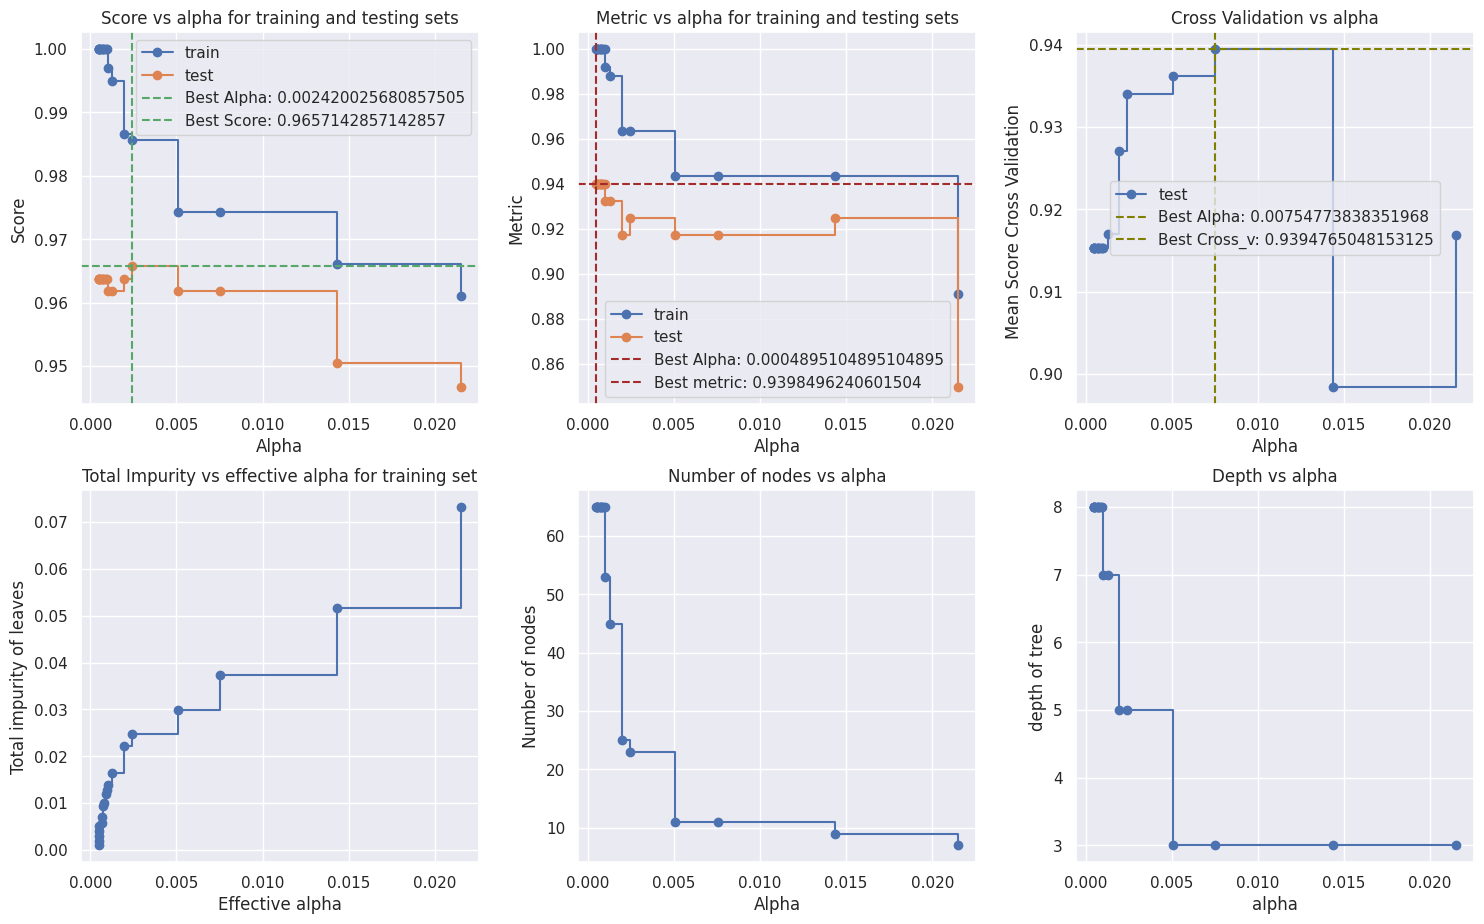

In [31]:
dta = cost_complexity_pruning_plot(
    ccp_alphas[1:-1],
    impurities[1:-1],
    node_counts[1:-1],
    depth[1:-1],
    train_scores[1:-1],
    test_scores[1:-1],
    cro_cv[1:-1],
    score_trainer[1:-1],
    score_test[1:-1],
    typ = 'C')

In [32]:
dta

,,ccp_alphas,value,impurities,nodes,depth
0,Score,0.00242,0.96571,0.02471,23,5
1,Metric,0.00049,0.93985,0.00098,65,8
2,cv-n,0.00755,0.93948,0.03733,11,3


Precision and recall are used to validate the model's performance.

In [33]:
model_clasification = DecisionTreeClassifier(random_state=random_seed)

model_clasification.fit(X_train, y_train)
y_predict = model_clasification.predict(X_test)

print(
    f'Precision: {precision_score(y_test, y_predict)}',
    f'Recall: {recall_score(y_test, y_predict)}'
)

Precision: 0.9191176470588235 Recall: 0.9398496240601504


In [34]:
model_clasification = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=0.00242)

model_clasification.fit(X_train, y_train)
y_predict = model_clasification.predict(X_test)

print(
    f'Precision: {precision_score(y_test, y_predict)}',
    f'Recall: {recall_score(y_test, y_predict)}'
)

Precision: 0.9389312977099237 Recall: 0.924812030075188


In [35]:
model_clasification = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=0.00049)

model_clasification.fit(X_train, y_train)
y_predict = model_clasification.predict(X_test)

print(
    f'Precision: {precision_score(y_test, y_predict)}',
    f'Recall: {recall_score(y_test, y_predict)}'
)

Precision: 0.9191176470588235 Recall: 0.9398496240601504


In [36]:
model_clasification = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=0.00755)

model_clasification.fit(X_train, y_train)
y_predict = model_clasification.predict(X_test)

print(
    f'Precision: {precision_score(y_test, y_predict)}',
    f'Recall: {recall_score(y_test, y_predict)}'
)

Precision: 0.9312977099236641 Recall: 0.9172932330827067


In classification problems, determining the best alpha is more complicated, as the goal is to achieve the highest score, which is typically achieved by the model without pruning. One way to determine the best alpha is by evaluating the best metric after the model with overfitting.

This time, I lean towards the alpha from cross-validation, as it is higher and has been validated with different data samples from the initial dataset, assessing how robust it will be across different scenarios. As well, of the interpretations of the scores and alphas.


# Notes:

- The metrics and their respective configurations depend on the data scientist, engineer, or professional, and on the context of the problem.

#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr